In [1]:
import copy

import numpy as np
import pandas as pd

from data.dataset import StockDataset
from data.macro import Macro
from data.scaler import HybridScaler
from data.split import StratifiedTimeSeriesSplit
from data.utils import sliding_window
from model.arima import grid_search
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset = StockDataset('^GSPC')
df = dataset.get_hist(start_date='1950-01-01', end_date='2021-10-23', time_interval='daily')

In [3]:
x1 = df
x2 = pd.concat(
    [dataset.lookback_agg(lookback_len=30), 
     dataset.lookback_agg(lookback_len=60), 
     dataset.lookback_agg(lookback_len=120)],
    axis=1)

y = dataset.get_change_forecast_label(forecast_len=30, is_up=False, method='past_all')

In [4]:
macro = Macro(token='wixdGr7AAc9_syvt6cFD')
macro_data = macro.get_macro()

ori_cols = [col for col in macro_data.columns if 'lag' not in col]
lag_cols = [col for col in macro_data.columns if 'lag' in col]

# x1 = x1.merge(macro_data[ori_cols], how='left', on='date')
# x2 = x2.merge(macro_data, how='left', on='date')

x2 = x2.merge(macro_data, how='left', on='date')
x2.apply(lambda x: x.first_valid_index()).max()

'1987-06-10'

In [5]:
# TRAIN_START = '1951-01-01'
TRAIN_START = '1988-01-10'
TEST_START = '2016-01-01'
TEST_END = '2019-12-01'

window_len = 60
scaler1 = HybridScaler()
scaler1.fit(x1[TRAIN_START:TEST_START])

scaler2 = HybridScaler()
trans_x2 = scaler2.fit_transform(x2)

indices, windows = sliding_window(scaler1.transform(x1), window_len=window_len, step_size=1)
train_start = (np.array(indices) <= TRAIN_START).sum()
test_start = (np.array(indices) <= TEST_START).sum()
test_end = (np.array(indices) <= TEST_END).sum()

train_x1 = windows[train_start:test_start]
train_x2 = trans_x2.loc[indices][train_start:test_start].values
train_y = y[indices][train_start:test_start].values
test_x1 = windows[test_start:test_end]
test_x2 = trans_x2.loc[indices][test_start:test_end].values
test_y = y[indices][test_start:test_end].values

split = TimeSeriesSplit(n_splits=10, test_size=120)
# split = StratifiedTimeSeriesSplit(n_splits=10, test_size=120, min_positive_ratio=0.25)

# Build up two-stage network

In [6]:
import torch

from model.double_encoder import DoubleEncoderModel

In [7]:
np.random.seed(1)
torch.manual_seed(1)

model = DoubleEncoderModel(x1_dim=x1.shape[1], x2_dim=x2.shape[1], dropout=0.01)

In [8]:
model.fit(train_x1, train_x2, train_y, max_epoch=200)

=== Training epoch: 1
--- Training Loss: 0.540317177772522, Training Accuracy: 0.740819509428612
=== Training epoch: 2
--- Training Loss: 0.5909417271614075, Training Accuracy: 0.7422373458102935
=== Training epoch: 3
--- Training Loss: 1.0970983505249023, Training Accuracy: 0.6444066354742662
=== Training epoch: 4
--- Training Loss: 6.255507469177246, Training Accuracy: 0.48546717708776405
=== Training epoch: 5
--- Training Loss: 2.639197826385498, Training Accuracy: 0.5837232383382958
=== Training epoch: 6
--- Training Loss: 1.9004745483398438, Training Accuracy: 0.44491705657167163
=== Training epoch: 7
--- Training Loss: 0.7557848691940308, Training Accuracy: 0.6564582447185595
=== Training epoch: 8
--- Training Loss: 0.8107502460479736, Training Accuracy: 0.5874096129306678
=== Training epoch: 9
--- Training Loss: 0.536613941192627, Training Accuracy: 0.7891677300439529
=== Training epoch: 10
--- Training Loss: 0.5101662874221802, Training Accuracy: 0.7992343683538919
=== Training

--- Training Loss: 0.32896026968955994, Training Accuracy: 0.8482915071600737
=== Training epoch: 84
--- Training Loss: 0.32801303267478943, Training Accuracy: 0.8499929108180916
=== Training epoch: 85
--- Training Loss: 0.3270052969455719, Training Accuracy: 0.8515525308379412
=== Training epoch: 86
--- Training Loss: 0.32599157094955444, Training Accuracy: 0.8532539344959592
=== Training epoch: 87
--- Training Loss: 0.3252728581428528, Training Accuracy: 0.8546717708776407
=== Training epoch: 88
--- Training Loss: 0.32492542266845703, Training Accuracy: 0.8552389054303133
=== Training epoch: 89
--- Training Loss: 0.3243640661239624, Training Accuracy: 0.8559478236211541
=== Training epoch: 90
--- Training Loss: 0.3235008418560028, Training Accuracy: 0.8563731745356585
=== Training epoch: 91
--- Training Loss: 0.3227899670600891, Training Accuracy: 0.8560896072593223
=== Training epoch: 92
--- Training Loss: 0.3227011263370514, Training Accuracy: 0.8560896072593223
=== Training epoch:

In [9]:
pred_y = model.predict(train_x1, train_x2)
pred_y_int = (pred_y >= 0.5).astype(int)
print(pred_y_int.sum(), train_y.sum())
confusion_matrix(train_y, pred_y_int.reshape(-1))

2075 1908


array([[4547,  598],
       [ 431, 1477]])

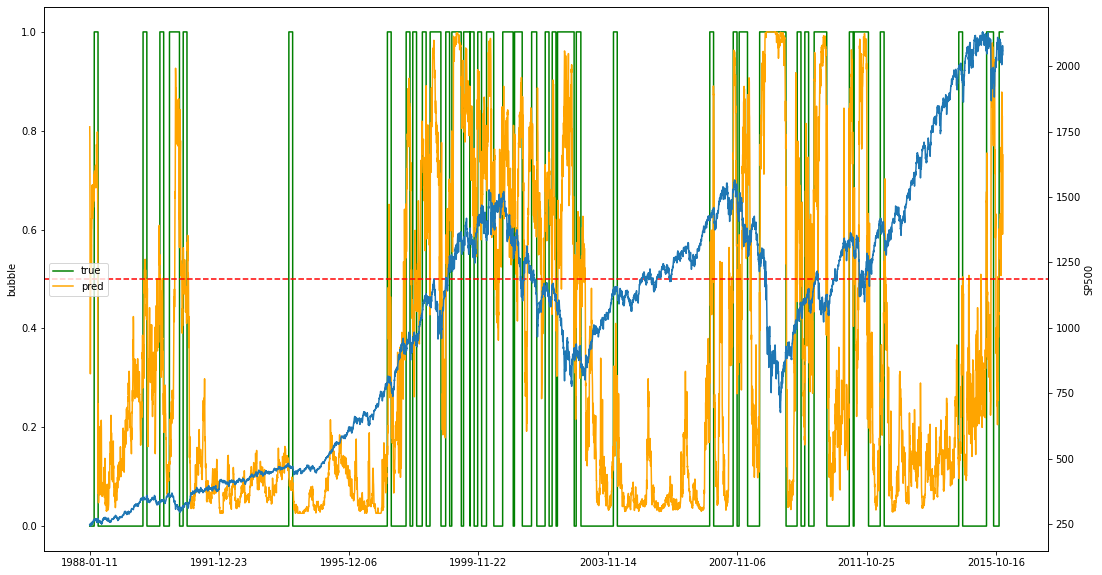

In [10]:
from model.eval import moving_average
import matplotlib.pyplot as plt

test_df = pd.DataFrame({'true': train_y, 'pred': pred_y.reshape(-1)})


ax1 = test_df.plot(figsize=(18, 10), color=['g', 'orange'])
ax1.set_ylabel('bubble')
ax1.axhline(y=0.5, color='r', linestyle='--')

ax2 = ax1.twinx() 
ax2.set_ylabel('SP500')
ax2 = x1.loc[indices[train_start:test_start], 'close'].plot()

In [11]:
pred_y = model.predict(test_x1, test_x2)
pred_y_int = (pred_y >= 0.5).astype(int)
print(pred_y_int.sum(), test_y.sum())
confusion_matrix(test_y, pred_y_int.reshape(-1))

260 224


array([[618, 143],
       [107, 117]])

In [12]:
from sklearn.metrics import fbeta_score
print(f'Accuracy: {(test_y == pred_y_int.reshape(-1)).mean()}')
print(f'F1:{fbeta_score(test_y, pred_y_int, beta=1)}')
print(f'F2:{fbeta_score(test_y, pred_y_int, beta=2)}')

Accuracy: 0.7461928934010152
F1:0.48347107438016534
F2:0.5060553633217993


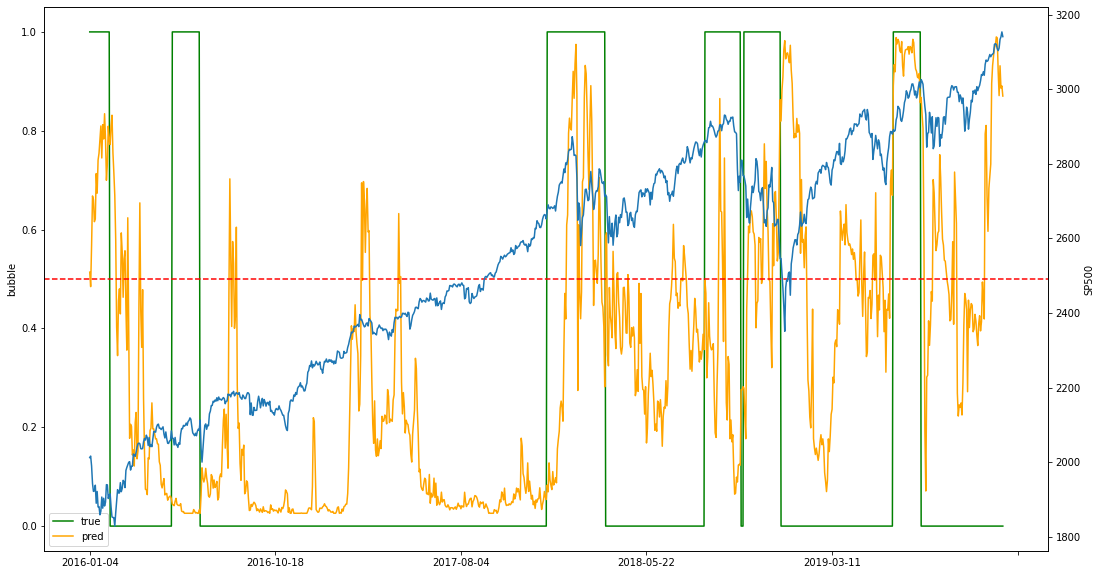

In [13]:
from model.eval import moving_average
import matplotlib.pyplot as plt

# test_df = moving_average(test_y, pipeline.predict_proba(test_x)[:, 1])
test_df = pd.DataFrame({'true': test_y, 'pred': pred_y.reshape(-1)})


ax1 = test_df.plot(figsize=(18, 10), color=['g', 'orange'])
ax1.set_ylabel('bubble')
ax1.axhline(y=0.5, color='r', linestyle='--')

ax2 = ax1.twinx() 
ax2.set_ylabel('SP500')
ax2 = x1.loc[indices[test_start:test_end], 'close'].plot()